In [16]:
library(ggplot2)
library(RColorBrewer)
library(scales)
library(stringr)
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(reshape2))
theme_set(theme_bw())
options(repr.plot.width=8, repr.plot.height=5)

# Introduction

We have learned a little bit about the eukaryotic identity elements. If we test the full set (50 bit+) of tRNAs versus the quality set, we can learn about and dig into areas where the quality set may not be so high quality, and where the discovered identity elements may be inaccurate. The quality set is a subset of the full set of tRNAs, and has filtered for a few things, such as secondary structure score and isotype model-anticodon matching.

In [60]:
identities = read.delim('identities.tsv', sep='\t')
identities$quality = as.logical(identities$quality)
identities$restrict = as.logical(identities$restrict)
identities = identities %>% mutate(quality=quality & (!restrict | isotype == "iMet"))

In [3]:
freqs = read.delim('best-freqs.tsv', sep='\t', header=TRUE, stringsAsFactors=FALSE)

## 20ab

tRNAs contain a variable number of [insertions at position 20](http://zam.soe.ucsc.edu:5959/notebooks/identity/euk-isotypes/euk-tRNAs.ipynb#20a/20b). Does the quality + restricted set show a different distribution compared with the full set?

In [4]:
identities %>% group_by(quality & !restrict) %>% summarize(n())

,quality & !restrict,n()
1,FALSE,63292
2,TRUE,46517


In [5]:
insertionab = identities %>% 
  rowwise() %>% mutate(insertionab=nchar(str_replace_all(paste0(X20a, X20b, X20i1, X20i2, X20i3, X20i4), '[\\.\\-]', ''))) %>%
  mutate(quality=quality & (!restrict | isotype == "iMet")) %>%
  group_by(quality, insertionab) %>%
  summarize(count=n())

Warning message:
: Grouping rowwise data frame strips rowwise nature

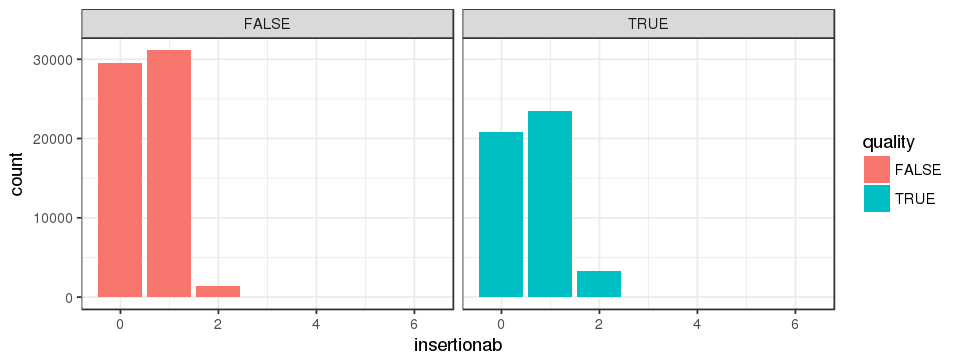

In [65]:
options(repr.plot.width=8, repr.plot.height=3)
insertionab %>% ggplot() + geom_bar(aes(x=insertionab, y=count, fill=quality), stat="identity") + facet_wrap(~ quality) 

## Anticodon usage

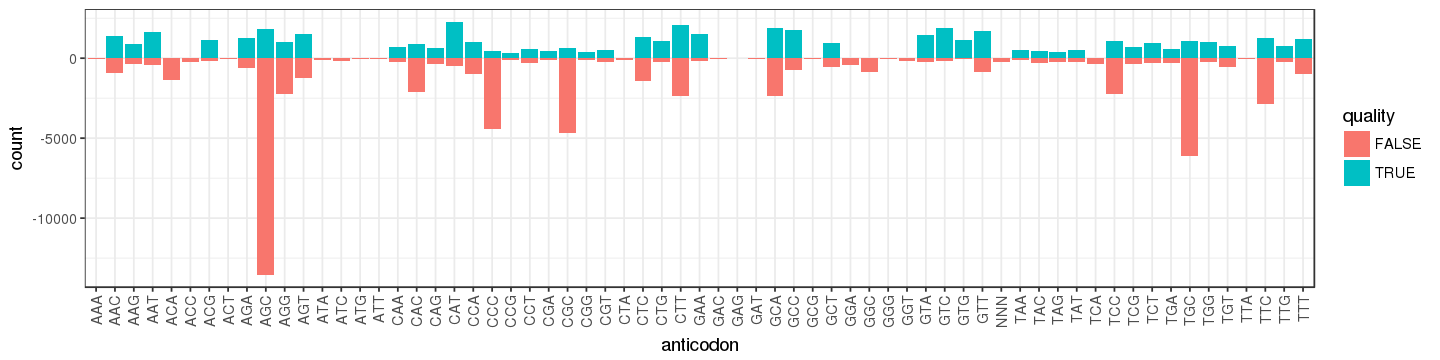

In [8]:
options(repr.plot.width=12, repr.plot.height=3)
ac_usage = identities %>% group_by(quality, anticodon) %>%
  summarize(count=n()) %>%
  rowwise %>% mutate(count=ifelse(quality[1], count[1], -count[1]))

ac_usage %>% ggplot() + geom_bar(aes(x=anticodon, y=count, fill=quality), stat='identity') + 
  theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.5))

## 3D pairs

In [68]:
pairs = c("A:U", "U:A", "G:C", "C:G", "G:U", "U:G")
tert_pairs = identities %>%
  select(quality, X8.14, X9.23, X10.45, X15.48, X18.55, X19.56, X22.46, X26.44, X54.58) %>%
  mutate(quality=ifelse(quality, "Quality set tRNAs", "Other tRNAs")) %>%
  mutate(quality=factor(quality, levels=c("Quality set tRNAs", "Other tRNAs"))) %>%
  rowwise() %>%
  mutate(n3dpairs=sum(c((X8.14 %in% pairs), (X9.23 %in% pairs), (X10.45 %in% pairs), (X15.48 %in% pairs), (X18.55 %in% pairs), (X19.56 %in% pairs), (X22.46 %in% pairs), (X26.44 %in% pairs), (X54.58 %in% pairs)))) %>%
  ungroup() %>%
  group_by(quality) %>%
  mutate(freq=n()) %>%
  group_by(quality, n3dpairs, freq) %>%
  summarize(count=n()) %>%
  mutate(freq=count/freq)

In [45]:
head(tert_pairs)

,quality,n3dpairs,freq,count
1,Quality set tRNAs,3,0.01363871,739
2,Quality set tRNAs,4,0.02177765,1180
3,Quality set tRNAs,5,0.417854,22641
4,Quality set tRNAs,6,0.432397,23429
5,Quality set tRNAs,7,0.1070796,5802
6,Quality set tRNAs,8,0.00714233,387


Warning message:
: Removed 2 rows containing missing values (geom_bar).

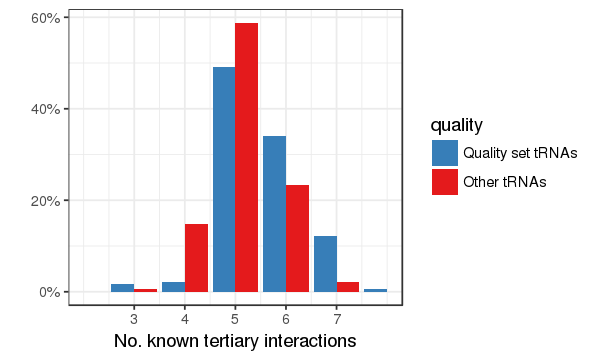

In [69]:
options(repr.plot.width=5, repr.plot.height=3)
tert_pairs %>% ggplot() + 
  geom_bar(aes(x=n3dpairs, y=freq, fill=quality), stat='identity', position='dodge') + 
  scale_x_continuous(limits=c(2, 8), breaks=c(3, 4, 5, 6, 7)) +
  scale_y_continuous(labels=percent_format()) +
  scale_fill_manual(values=rev(brewer.pal(3, "Set1")[1:2])) + 
  ylab("") + xlab("No. known tertiary interactions")

## Mismatched pairs

In [23]:
paired_positions = c('X2.71', 'X3.70', 'X4.69', 'X5.68', 'X6.67', 'X7.66', 'X10.25', 'X11.24', 'X12.23', 'X13.22', 'X27.43', 'X28.42', 'X29.41', 'X30.40', 'X31.39', 'X49.65', 'X50.64', 'X51.63', 'X52.62', 'X53.61')
mm_pairs = c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C")
mismatched = identities %>% select(one_of("quality", paired_positions)) %>%
  mutate(quality=ifelse(quality, "Quality set tRNAs", "Other tRNAs")) %>%
  mutate(quality=factor(quality, levels=c("Quality set tRNAs", "Other tRNAs"))) %>%
  rowwise() %>%
  mutate(npairs=sum(c(X2.71 %in% mm_pairs), (X3.70 %in% mm_pairs), (X4.69 %in% mm_pairs), (X5.68 %in% mm_pairs), (X6.67 %in% mm_pairs), (X7.66 %in% mm_pairs), (X10.25 %in% mm_pairs), (X11.24 %in% mm_pairs), (X12.23 %in% mm_pairs), (X13.22 %in% mm_pairs), (X27.43 %in% mm_pairs), (X28.42 %in% mm_pairs), (X29.41 %in% mm_pairs), (X30.40 %in% mm_pairs), (X31.39 %in% mm_pairs), (X49.65 %in% mm_pairs), (X50.64 %in% mm_pairs), (X51.63 %in% mm_pairs), (X52.62 %in% mm_pairs), (X53.61 %in% mm_pairs)))

Warning message:
: Removed 2 rows containing non-finite values (stat_count).Warning message:
: Removed 2 rows containing missing values (geom_bar).

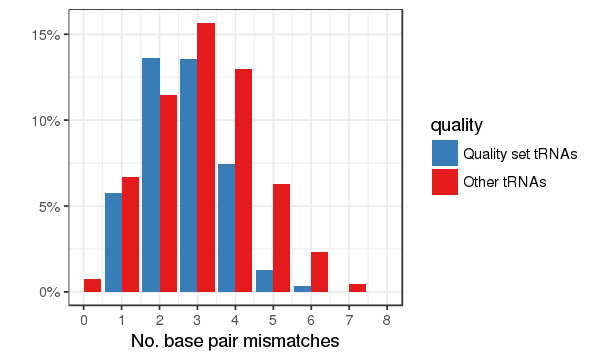

In [31]:
options(repr.plot.width=5, repr.plot.height=3)
mismatched %>% ggplot() + 
  geom_bar(aes(x=npairs, y=(..count..)/sum(..count..), fill=quality), position='dodge') + 
  scale_x_continuous(limits=c(0, 8), breaks=c(0, 1, 2, 3, 4, 5, 6, 7, 8)) +
  scale_y_continuous(labels=percent_format()) +
  scale_fill_manual(values=rev(brewer.pal(3, "Set1")[1:2])) + 
  ylab("") + xlab("No. base pair mismatches")